In [5]:
import os
os.chdir('..\\..')

In [14]:
import networkx as nx
import numpy as np
import pandas as pd
import collections

# Start with pct% of population infected
def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman', pop_size = 1000):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(int(pop_size/4), 4, 0.25, seed=42)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(pop_size)
    else:
        raise ValueError("Unknown graph type")
        
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model):
    G = init_graph(initial_infection, graph_model)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop

def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """
    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size)
    
    for node in G.nodes():
        if node in infected: 
            G.nodes[node].update({'status' : 'infected',
                                  'infection_day': 0, 
                                  'contacts_infected': 0})
        else:
            G.nodes[node].update({'status': 'susceptible', 
                                  'infection_day' : -1, 
                                  'contacts_infected': 0})



def recover_one_step(G, day, recover_time = 12):
    """
    Recover everyone that has been infected recover_time days or more
    """

    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'infected':
            if day - G.nodes[node]['infection_day'] >= recover_time: 
                G.nodes[node]['status'] = 'recovered'

def spread_one_step(G, day, p_r = 0.5, lambda_leak = 0.05):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day
    """
    newly_infected = []
       
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                newly_infected.append(node)    
            else:
                for contact in adjacencies[1].keys():
                    if G.nodes[contact]['status'] == 'infected' and np.random.random() < p_r:
                            newly_infected.append(node)
                            G.nodes[contact]['contacts_infected'] += 1
                            break  
        
    for node in np.unique(newly_infected):
        G.nodes[node].update({'status' : 'infected', 'infection_day': day})
        
    return len(newly_infected)


def simulate_one_step(G, day, recover_time=12, p_r=0.5, infectious_window=[4,6]):
    """
    Recover and Spread one step
    """
    recover_one_step(G, day, recover_time)
    newly_infected =  spread_one_step(G, day, p_r, infectious_window)
    return newly_infected

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and recovered
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result
    
    
def simulate_pandemic(initial_infection=.05, recover_time=12, p_r=.5, 
                          lambda_leak=.05, graph_model = 'relaxed_caveman'):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    
    G, data, status, pop = init_parameters(initial_infection, graph_model)

    day = 0
    while status['infected']>(.01*pop) and  (status['recovered']+status['susceptible'])<pop:
        day +=1
        
        recover_one_step(G, day, recover_time)
        
        newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        status = current_status(G)
        i = status['infected'] / pop
        s = status['susceptible'] / pop
        r = status['recovered'] / pop
        
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True) if node['status'] == 'recovered']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
        data.append([s, i, r, newly_infected, contacts_infected])
    columns = ['susceptible', 'infected', 'recovered', 'newly_infected', 'contacts_infected_mean']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series


In [76]:
def sample_incubation_period(log_mean=1.611195, log_sigma=0.47238, mean=None, sigma=None):
    """
        We are modeling the incubation time as a lognormal distribution with mean of 
        Mean: 5.6, Standar Deviation: 2.8. If we wish to chance the mean or SD, just need
        to input the new values, either as mean and sigma or log_mean and log_sigma
        
        source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7074197/
    """
    if mean and sigma: 
        log_mean = np.log(mean) - .5*np.log(((sigma/mean)**2)+1)
        log_sd = np.sqrt(np.log((sigma/mean)**2 + 1))

    return np.random.lognormal(mean = log_mean, sigma =  log_sigma)

def sample_onset_to_hosp(shape = 0.617347, scale=5.3454546, mean=None, sigma=None):
    """
        We are modeling the onset to hospitalization time as a gamma distribution with mean of 
        Mean: 3.3, Standard Deviation: 4.2. If we wish to chance the mean or SD, just need
        to input the new values, either as mean and sigma or shape and scale
        
        source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7074197/
    """
    
    if mean and sigma:
        shape = (mean**2)/(sd**2)
        scale = (sd**2)/mean

    return np.random.gamma(shape, scale)

In [78]:
from scipy.stats import gamma

In [81]:
gamma.cdf(range(0,50), 0.617347, 1/5.3454546)

array([0.        , 0.74134837, 0.92232604, 0.97484645, 0.99157842,
       0.99712574, 0.99900661, 0.99965359, 0.9998784 , 0.99995709,
       0.9999848 , 0.99999459, 0.99999807, 0.99999931, 0.99999975,
       0.99999991, 0.99999997, 0.99999999, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

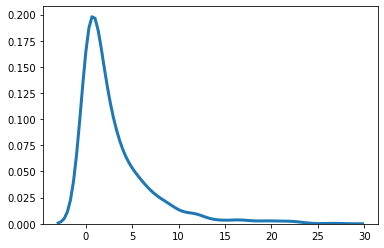

In [91]:
sns.distplot([sample_onset_to_hosp() for x in range(1000)],
             hist = False, kde = True, kde_kws = {'linewidth': 3})


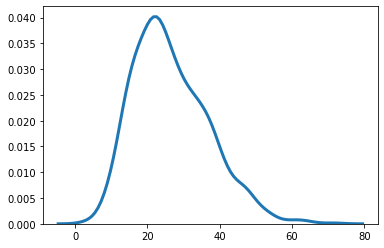

In [90]:
sns.distplot([sample_onset_to_hosp(6.5, 4) for x in range(1000)],
             hist = False, kde = True, kde_kws = {'linewidth': 3})
